# Question Answer Extraction Model Evaluation

## 1. Packages and params

In [3]:
import os, sys, argparse, gc
import pandas as pd
import numpy as np

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, create_optimizer, DefaultDataCollator, AdamWeightDecay
import datasets

In [4]:
model_name = "bert-base-multilingual-cased"
maxlen = 512
stride = 128
batch_size = 16

## 2. Load Test Data

In [5]:
df_test = pd.read_csv("datasets/test.csv")
df_test.drop("title", axis=1, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   context       2068 non-null   object
 1   question      2068 non-null   object
 2   answer        2068 non-null   object
 3   answer_start  2068 non-null   int64 
 4   answer_end    2068 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 80.9+ KB


<AxesSubplot:>

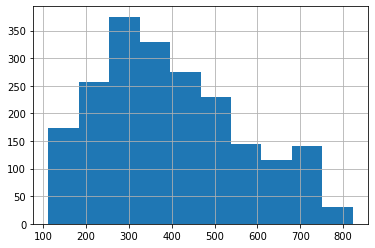

In [6]:
df_test["context_len"] = df_test["context"].apply(lambda x: len(x.split()))
df_test["context_len"].hist()

## 3. Prepare Test dataset

In [8]:
def preprocess_dataset(ds, tokenizer, maxlen, stride):
    questions = [q.strip() for q in ds["question"]]
    inputs = tokenizer(
        questions,
        ds["context"],
        max_length=maxlen,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    # answers = ds["answer"]
    answer_starts = ds["answer_start"]
    answer_ends = ds["answer_end"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        # answer = answers[sample_idx]
        start_char = answer_starts[sample_idx]
        end_char = answer_ends[sample_idx]
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [153]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [184]:
ds_test = datasets.Dataset.from_dict(df_test)

dataset_test = ds_test.map(
    lambda ds: preprocess_dataset(ds, tokenizer, maxlen, stride),
    batched=True,
    remove_columns=ds_test.column_names,
)
len(ds_test), len(dataset_test)

  0%|          | 0/3 [00:00<?, ?ba/s]

(2068, 3291)

In [185]:
dataset_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 3291
})

In [186]:
dataset_test[0]['end_positions']

20

In [187]:
data_collator = DefaultDataCollator(return_tensors="tf")
tf_dataset_test = dataset_test.to_tf_dataset(
    columns=[
        "input_ids",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=batch_size,
)

## 4. Load model

In [177]:
# model = tf.keras.models.load_model(f"models/{model_name}", compile=False)
model = TFAutoModelForQuestionAnswering.from_pretrained(model_name)
model.load_weights(f"models/{model_name}")

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2022-09-04 13:56:02.395524: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/bert-base-multilingual-cased: FAILED_PRECONDITION: models/bert-base-multilingual-cased; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [178]:
model.summary()

Model: "tf_bert_for_question_answering_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177262848 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 177,264,386
Trainable params: 177,264,386
Non-trainable params: 0
_________________________________________________________________


## 5. Predict

In [265]:
def tokenize_question_context(question, context, tokenizer, maxlen, stride):
    question = question.strip()
    context = context.strip()
    inputs = tokenizer(
        question,
        context,
        max_length=maxlen,
        truncation="only_second",
        stride=stride,
        # return_overflowing_tokens=True,
        # return_offsets_mapping=True,
        padding="max_length",
        return_tensors="tf"
    )

    return inputs

In [266]:
def predict(model, question, context, tokenizer, maxlen, stride):
    inputs = tokenize_question_context(question, context, tokenizer, maxlen, stride)
    outputs = model(**inputs)

    start_logits = outputs["start_logits"].numpy()
    end_logits = outputs["end_logits"].numpy()

    starts = np.argmax(start_logits, axis=1)
    ends = np.argmax(end_logits,  axis=1)

    start_scores = np.max(start_logits, axis=1)
    end_scores = np.max(end_logits, axis=1)
    scores = start_scores + end_scores

    indices = []
    for idx, start in enumerate(starts):
        end = ends[idx]
        if start == 0 and end == 0:
            continue
        if end < start:
            continue
        indices.append(idx)

    answers = []
    for idx in indices:
        score = scores[idx]
        ans_ids = inputs["input_ids"][idx][starts[idx]:ends[idx]+1]
        answer = tokenizer.decode(ans_ids, skip_special_tokens=True)
        answers.append((answer, score))
    return answers

In [214]:
df = df_test[df_test["context_len"] > 500]
df.head()

,context,question,answer,answer_start,answer_end,context_len
30,"Từ một cô gái năng động, hoạt bát, trầm cảm kh...","Từ một cô gái năng động, hoạt bát, bệnh gì khi...",trầm cảm,35,43,727
31,"Từ một cô gái năng động, hoạt bát, trầm cảm kh...",Cô có những biểu hiện như thế nào với tất cả n...,"lầm lỳ, buồn chán và sợ hãi",115,142,727
32,"Từ một cô gái năng động, hoạt bát, trầm cảm kh...",Cô ấy nghĩ gì để giải thoát những nổi ám ảnh?,tự tử,321,326,727
33,"Từ một cô gái năng động, hoạt bát, trầm cảm kh...","Nghe theo lời khuyên của huấn luyện viên, Linh...",khóa tu Vipassana (thiền tịnh khẩu) trong một ...,948,1032,727
34,"Từ một cô gái năng động, hoạt bát, trầm cảm kh...",Mai Linh bây giờ đã biết những gì?,"yêu thương bản thân, bớt sợ hãi và dễ dàng tìm...",3223,3321,727


In [274]:
df_test.head()

,context,question,answer,answer_start,answer_end,context_len
0,Ông Bình phát hiện ung thư thanh quản cách đây...,Cách đây 3 năm ông Bình mắc bệnh gì?,ung thư thanh quản,19,37,388
1,Ông Bình phát hiện ung thư thanh quản cách đây...,"Với kỹ thuật cũ, liệu trình trị xạ là bao nhiê...",30 lần,1263,1269,388
2,Ông Bình phát hiện ung thư thanh quản cách đây...,Phương pháp mới có ngưỡng sai số là bao nhiêu?,một mm,1451,1457,388
3,Ông Bình phát hiện ung thư thanh quản cách đây...,Kỹ thuật mới áp dụng cho những trường hợp nào?,"bướu nhỏ, giai đoạn sớm, tái phát còn khu trú ...",1589,1722,388
4,Ông Bình phát hiện ung thư thanh quản cách đây...,"Với kỹ thuật cũ, ngưỡng sai số của liều xạ là ...",lên đến 5-10 mm,1294,1309,388


In [277]:
idx = 4
# question = df.loc[idx, "question"]
# context = df.loc[idx, "context"]
question = df_test.loc[idx, "question"]
context = df_test.loc[idx, "context"]

answers = predict(model, question, context, tokenizer, maxlen, stride)
print(answers)

[('30 lần và ngưỡng sai số có thể lên đến 5 - 10 mm', 17.33732)]


## 6. Evaluation

In [282]:
start_positions = dataset_test['start_positions']
end_positions = dataset_test['end_positions']

len(start_positions), len(end_positions)

(3291, 3291)

In [278]:
predictions = model.predict(tf_dataset_test)

206/206 [==============================] - 2140s 10s/step


In [285]:
start_logits = predictions.start_logits
end_logits = predictions.end_logits

pred_start_positions = np.argmax(start_logits, axis=1)
pred_end_positions = np.argmax(end_logits, axis=1)

len(pred_start_positions), len(pred_end_positions)

(3291, 3291)

In [286]:
acc = 0
for i, start in enumerate(start_positions):
    end = end_positions[i]
    pred_start = pred_start_positions[i]
    pred_end = pred_end_positions[i]
    if start == pred_start and end == pred_end:
        acc += 1

acc /= len(start_positions)
print("Accuracy :", acc)

Accuracy : 0.6274688544515344


## 7. Evaluation xlm-roberta-base

In [287]:
model_name = "xlm-roberta-base"

In [288]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [289]:
ds_test = datasets.Dataset.from_dict(df_test)

dataset_test = ds_test.map(
    lambda ds: preprocess_dataset(ds, tokenizer, maxlen, stride),
    batched=True,
    remove_columns=ds_test.column_names,
)
len(ds_test), len(dataset_test)

  0%|          | 0/3 [00:00<?, ?ba/s]

(2068, 3069)

In [290]:
data_collator = DefaultDataCollator(return_tensors="tf")
tf_dataset_test = dataset_test.to_tf_dataset(
    columns=[
        "input_ids",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=batch_size,
)

In [291]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_name)
model.load_weights(f"models/{model_name}")

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForQuestionAnswering.

Some layers of TFXLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2022-09-04 16:54:04.791233: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/xlm-roberta-base: FAILED_PRECONDITION: models/xlm-roberta-base; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [292]:
start_positions = dataset_test['start_positions']
end_positions = dataset_test['end_positions']

len(start_positions), len(end_positions)

(3069, 3069)

In [293]:
predictions = model.predict(tf_dataset_test)

192/192 [==============================] - 2140s 11s/step


In [294]:
start_logits = predictions.start_logits
end_logits = predictions.end_logits

pred_start_positions = np.argmax(start_logits, axis=1)
pred_end_positions = np.argmax(end_logits, axis=1)

len(pred_start_positions), len(pred_end_positions)

(3069, 3069)

In [295]:
acc = 0
for i, start in enumerate(start_positions):
    end = end_positions[i]
    pred_start = pred_start_positions[i]
    pred_end = pred_end_positions[i]
    if start == pred_start and end == pred_end:
        acc += 1

acc /= len(start_positions)
print("Accuracy :", acc)

Accuracy : 0.6480938416422287


## 8. Evaluation xlm-roberta-base

In [17]:
model_name = "xlm-roberta-large"

In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [19]:
ds_test = datasets.Dataset.from_dict(df_test)

dataset_test = ds_test.map(
    lambda ds: preprocess_dataset(ds, tokenizer, maxlen, stride),
    batched=True,
    remove_columns=ds_test.column_names,
)
len(ds_test), len(dataset_test)

  0%|          | 0/3 [00:00<?, ?ba/s]

(2068, 3069)

In [20]:
data_collator = DefaultDataCollator(return_tensors="tf")
tf_dataset_test = dataset_test.to_tf_dataset(
    columns=[
        "input_ids",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=batch_size,
)

In [21]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_name)
model.load_weights(f"models/{model_name}")

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaForQuestionAnswering.

Some layers of TFXLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2022-09-05 12:14:13.828560: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/xlm-roberta-large: FAILED_PRECONDITION: models/xlm-roberta-large; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [22]:
start_positions = dataset_test['start_positions']
end_positions = dataset_test['end_positions']

len(start_positions), len(end_positions)

(3069, 3069)

In [23]:
predictions = model.predict(tf_dataset_test)

192/192 [==============================] - 7266s 38s/step


In [24]:
start_logits = predictions.start_logits
end_logits = predictions.end_logits

pred_start_positions = np.argmax(start_logits, axis=1)
pred_end_positions = np.argmax(end_logits, axis=1)

len(pred_start_positions), len(pred_end_positions)

(3069, 3069)

In [25]:
acc = 0
for i, start in enumerate(start_positions):
    end = end_positions[i]
    pred_start = pred_start_positions[i]
    pred_end = pred_end_positions[i]
    if start == pred_start and end == pred_end:
        acc += 1

acc /= len(start_positions)
print("Accuracy :", acc)

Accuracy : 0.6966438579341805
